In [1]:
# Bibliothèques Générales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles Statistiques Traditionnels
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Apprentissage Automatique
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Conv1D, MaxPooling1D, Flatten

# XGBoost
import xgboost as xgb

# Transformers (Time Series)
# from transformers import TimeSeriesTransformer

from darts.models import TransformerModel

# Ensemble Learning
from sklearn.ensemble import VotingRegressor, StackingRegressor

import yfinance as yf

# Analyse Technique
import talib

In [2]:
from datetime import date

In [3]:
# On commence par récupérer les données du CAC40 sur yahoo finance

aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')
aujourdhui

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices 
# boursiers de Reuters, sont ticker est ^FCHI

# start="2020-01-01", end="2023-12-31"
# start='2020-01-01', end=aujourdhui
ticker = '^FCHI' 
cac40 = yf.download(ticker, start="2020-01-01", end="2023-12-31")
cac40

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,6016.609863,6062.919922,6011.209961,6041.500000,6041.500000,63958300
2020-01-03,6007.959961,6044.160156,5994.589844,6044.160156,6044.160156,60488000
2020-01-06,6001.209961,6017.970215,5955.250000,6013.589844,6013.589844,69063700
2020-01-07,6033.220215,6065.740234,6000.000000,6012.350098,6012.350098,69593800
2020-01-08,5986.810059,6031.000000,5972.770020,6031.000000,6031.000000,71431600
...,...,...,...,...,...,...
2023-12-21,7557.160156,7574.709961,7537.810059,7571.399902,7571.399902,36202800
2023-12-22,7560.970215,7589.000000,7557.580078,7568.819824,7568.819824,31755700
2023-12-27,7580.970215,7603.270020,7560.540039,7571.819824,7571.819824,31599200


In [4]:
ticker = "^FCHI"

# Obtenir l'objet Ticker
cac = yf.Ticker(ticker)

# Vérifier les dividendes
dividends = cac.dividends
print("Dividendes :")
print(dividends)

# Vérifier les splits d'actions
splits = cac.splits
print("Splits d'Actions :")
print(splits)


# Afficher les premières lignes des données
print(cac40[['Close', 'Adj Close']].head())

Dividendes :
Series([], Name: Dividends, dtype: float64)
Splits d'Actions :
Series([], Name: Stock Splits, dtype: float64)
                  Close    Adj Close
Date                                
2020-01-02  6041.500000  6041.500000
2020-01-03  6044.160156  6044.160156
2020-01-06  6013.589844  6013.589844
2020-01-07  6012.350098  6012.350098
2020-01-08  6031.000000  6031.000000


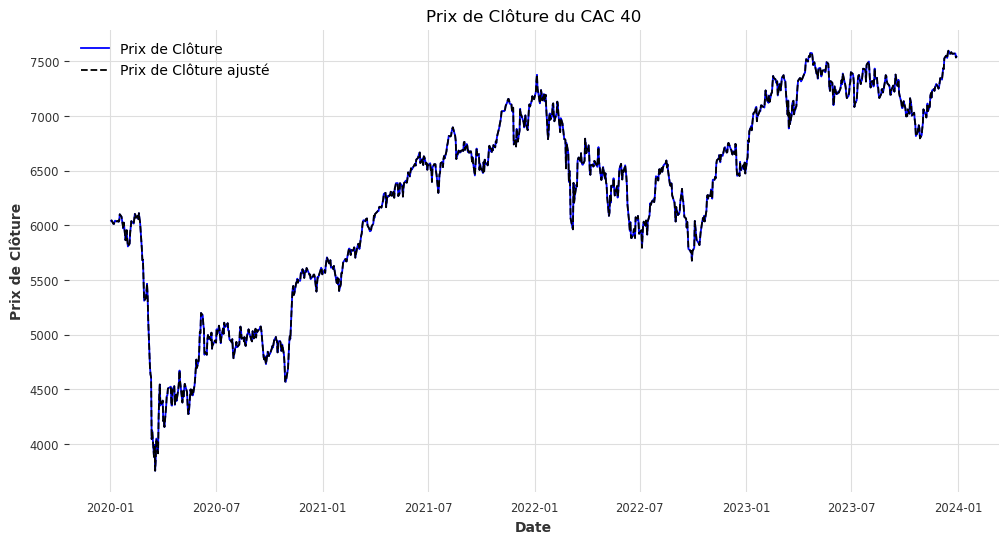

In [5]:
# Tracer les prix de clôture
plt.figure(figsize=(12, 6))
plt.plot(cac40['Close'], label="Prix de Clôture", color='blue')
plt.plot(cac40['Adj Close'], label='Prix de Clôture ajusté', color='black', linestyle='--')
plt.title("Prix de Clôture du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix de Clôture")
plt.legend()
plt.grid(True)

Petite vérification pour voir si TOTAL (entreprise du CAC40) a versé des dividendes ou a réalisé un SPLIT sur la période, ce qui devrait donner une différence entre le cours de clôture et le cours de clôture ajusté

[*********************100%%**********************]  1 of 1 completed

Dividendes pour TTE.PA:
Date
2000-06-14 00:00:00+02:00    0.5875
2001-05-29 00:00:00+02:00    0.8250
2002-05-17 00:00:00+02:00    0.9500
2003-05-16 00:00:00+02:00    1.0250
2004-05-19 00:00:00+02:00    0.1575
                              ...  
2023-06-21 00:00:00+02:00    0.7400
2023-09-20 00:00:00+02:00    0.7400
2024-01-02 00:00:00+01:00    0.7400
2024-03-20 00:00:00+01:00    0.7400
2024-06-19 00:00:00+02:00    0.7900
Name: Dividends, Length: 74, dtype: float64
Splits d'Actions pour TTE.PA:
Date
2006-05-18 00:00:00+02:00    4.0
Name: Stock Splits, dtype: float64
                Close  Adj Close
Date                            
2020-01-02  49.814999  36.635105
2020-01-03  50.380001  37.050625
2020-01-06  50.439999  37.587154
2020-01-07  50.110001  37.341255
2020-01-08  50.240002  37.438122


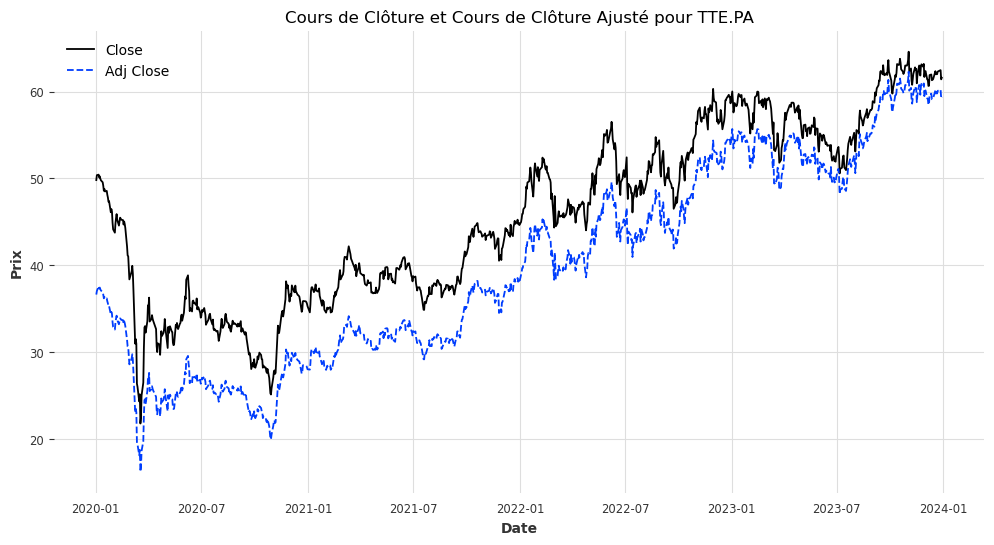

In [6]:
total_ticker = "TTE.PA"
total = yf.Ticker(total_ticker)

# Vérifier les dividendes pour TotalEnergies
total_dividends = total.dividends
print(f"Dividendes pour {total_ticker}:")
print(total_dividends)

# Vérifier les splits d'actions pour TotalEnergies
total_splits = total.splits
print(f"Splits d'Actions pour {total_ticker}:")
print(total_splits)

# Télécharger les données historiques pour comparer Close et Adj Close pour TotalEnergies
total_data = yf.download(total_ticker, start="2020-01-01", end="2023-12-31")

# Afficher les premières lignes des données
print(total_data[['Close', 'Adj Close']].head())

# Tracer les cours de clôture et les cours de clôture ajustés pour TotalEnergies
plt.figure(figsize=(12, 6))
plt.plot(total_data['Close'], label="Close")
plt.plot(total_data['Adj Close'], label="Adj Close", linestyle='--')
plt.title(f"Cours de Clôture et Cours de Clôture Ajusté pour {total_ticker}")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

S&P500 vérification des ajustements de cours de clôture

[*********************100%%**********************]  1 of 1 completed


                  Close    Adj Close
Date                                
2020-01-02  3257.850098  3257.850098
2020-01-03  3234.850098  3234.850098
2020-01-06  3246.280029  3246.280029
2020-01-07  3237.179932  3237.179932
2020-01-08  3253.050049  3253.050049


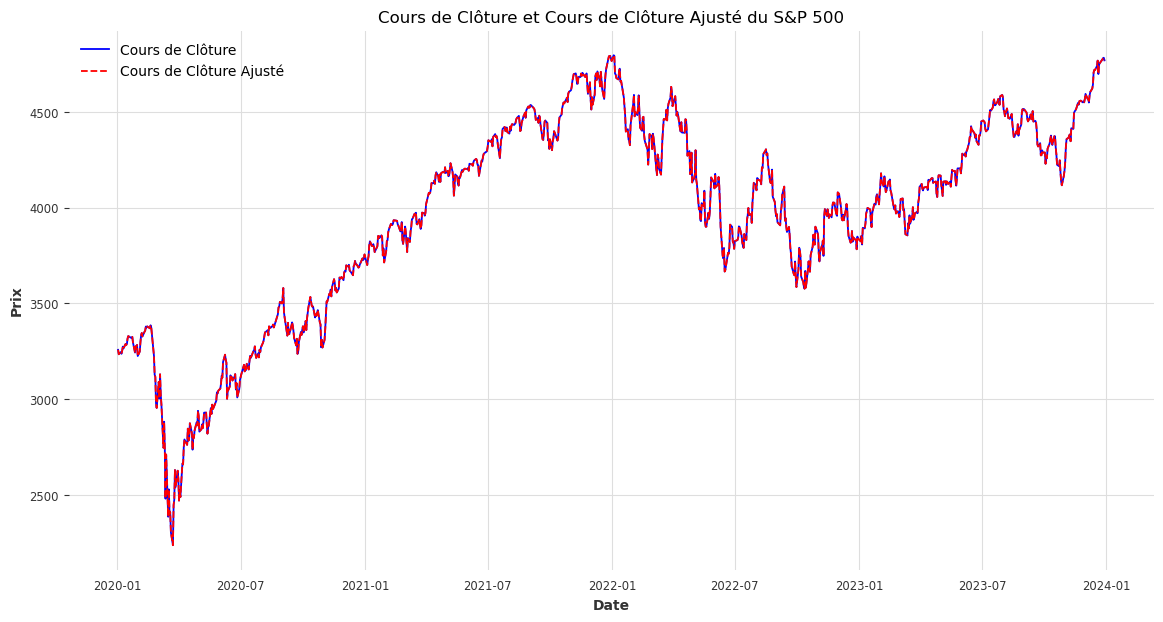

In [7]:
import yfinance as yf
import matplotlib.pyplot as plt

# Définir le ticker pour le S&P 500
ticker = "^GSPC"  # Ticker de l'indice S&P 500 sur Yahoo Finance

# Télécharger les données historiques pour le S&P 500
sp500_data = yf.download(ticker, start="2020-01-01", end="2023-12-31")

# Afficher les premières lignes des données
print(sp500_data[['Close', 'Adj Close']].head())

# Tracer les cours de clôture et les cours de clôture ajustés
plt.figure(figsize=(14, 7))

# Tracer les cours de clôture
plt.plot(sp500_data['Close'], label="Cours de Clôture", color='blue')

# Tracer les cours de clôture ajustés
plt.plot(sp500_data['Adj Close'], label="Cours de Clôture Ajusté", linestyle='--', color='red')

# Ajouter des titres et des labels
plt.title("Cours de Clôture et Cours de Clôture Ajusté du S&P 500")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

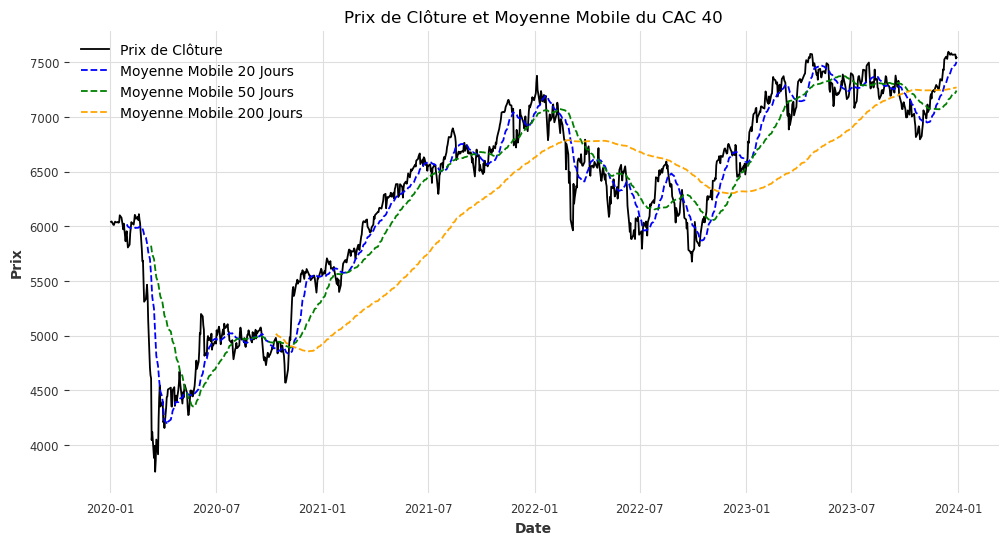

In [8]:
# Calculer la moyenne mobile simple sur 50 jours
# par défaut window prend le nombre d'observation, ici on demande 50 et comme nos cours de bourse
# sont journaliers ont moyenne sur les 50 derniers jours de bourse ouvrés
cac40['Moyenne_mobile_20'] = cac40['Adj Close'].rolling(window=20).mean()
cac40['Moyenne_mobile_50'] = cac40['Adj Close'].rolling(window=50).mean()
cac40['Moyenne_mobile_200'] = cac40['Adj Close'].rolling(window=200).mean()

# Calculer les moyennes mobiles exponentielles (EMA)
cac40['Exp_moyenne_mobile_12'] = cac40['Adj Close'].ewm(span=12, adjust=False).mean()
cac40['Exp_moyenne_mobile_26'] = cac40['Adj Close'].ewm(span=26, adjust=False).mean()



# Tracer les prix de clôture et la moyenne mobile
plt.figure(figsize=(12, 6))
plt.plot(cac40['Adj Close'], label="Prix de Clôture")
plt.plot(cac40['Moyenne_mobile_20'], label="Moyenne Mobile 20 Jours", linestyle='--', color='blue')
plt.plot(cac40['Moyenne_mobile_50'], label="Moyenne Mobile 50 Jours", linestyle='--', color='green')
plt.plot(cac40['Moyenne_mobile_200'], label="Moyenne Mobile 200 Jours", linestyle='--', color='orange')

# plt.plot(cac40['Exp_moyenne_mobile_12'], label="Moyenne Mobile Expo 12 Jours", color='gold')
# plt.plot(cac40['Exp_moyenne_mobile_26'], label="Moyenne Mobile Expo 26 Jours", color='darkorange')


plt.title("Prix de Clôture et Moyenne Mobile du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

# 1. Concept de l'EMA

La Moyenne Mobile Exponentielle (EMA) est une version plus réactive de la moyenne mobile. Contrairement à la SMA, qui accorde le même poids à chaque prix dans la période, l'EMA donne plus de poids aux prix récents. Cela la rend plus sensible aux changements récents du marché.

# 2. Calcul de l'EMA

Le calcul de l'EMA implique deux étapes principales :

## Calcul du facteur de lissage

Ce facteur est déterminé par la période choisie. Il est calculé comme suit :

$$
\text{Facteur de lissage} = \frac{2}{\text{Période} + 1}
$$

Pour une EMA de 12 jours, le facteur de lissage est

$$
\frac{2}{12 + 1} \approx 0.1538
$$

## Application du facteur de lissage

L'EMA est calculée en utilisant la formule récursive :

$$
\text{EMA}_{\text{aujourd'hui}} = (\text{Prix}_{\text{aujourd'hui}} \times \text{Facteur de lissage}) + (\text{EMA}_{\text{hier}} \times (1 - \text{Facteur de lissage}))
$$

L'EMA est donc une combinaison du prix actuel et de l'EMA précédente, pondérée par le facteur de lissage.

# 3. Périodes Courtes de l'EMA

- **EMA 12 jours** : Utilisée pour capturer les tendances à court terme. Elle est plus réactive aux changements de prix récents.
- **EMA 26 jours** : Utilisée pour capturer les tendances intermédiaires. Elle est moins réactive que l'EMA de 12 jours, mais plus réactive que les moyennes mobiles plus longues.

# 4. Utilisation des EMA

Les EMA sont souvent utilisées dans les stratégies de trading pour identifier les tendances et les signaux de trading :

- **Croisement des EMA** : Lorsque l'EMA de courte période (comme 12 jours) croise au-dessus de l'EMA de longue période (comme 26 jours), cela peut être un signal d'achat. Inversement, lorsque l'EMA de courte période croise en dessous de l'EMA de longue période, cela peut être un signal de vente.

- **MACD (Moving Average Convergence Divergence)** : L'EMA est également utilisée dans le calcul du MACD, un indicateur populaire pour détecter les changements de tendance en utilisant la différence entre deux EMA (généralement 12 jours et 26 jours) et une EMA de signal (souvent 9 jours).


#### Pour le calcul de la première valeur de l'EMA on fait une simple moyenne mobile, puis pour les valeurs suivantes on applique le principe expliqué ci-dessus, voici un exemple pour que vous compreniez

# Exemple
Supposons que nous voulons calculer une EMA de 5 jours pour une série de prix donnés. Voici les étapes concrètes :

## Déterminer le facteur de lissage :

$$
\alpha = \frac{2}{5 + 1} = \frac{2}{6} = 0.3333
$$

## Calculer l'EMA initiale (SMA des 5 premiers jours) :

Si les prix des 5 premiers jours sont 10, 11, 12, 13, et 14 :

$$
\text{SMA} = \frac{10 + 11 + 12 + 13 + 14}{5} = \frac{60}{5} = 12
$$

Donc,

$$
\text{EMA}_1 = 12
$$

## Calculer l'EMA pour les jours suivants :

Supposons que le prix du 6ème jour est 15 :

$$
\text{EMA}_6 = \alpha \times \text{Prix}_6 + (1 - \alpha) \times \text{EMA}_5
$$

$$
\text{EMA}_6 = 0.3333 \times 15 + (1 - 0.3333) \times 12
$$

$$
\text{EMA}_6 = 0.3333 \times 15 + 0.6667 \times 12
$$

$$
\text{EMA}_6 = 5 + 8 = 13
$$

Ainsi, l'EMA pour le 6ème jour est 13.

En répétant ce calcul pour chaque jour suivant, vous pouvez obtenir les valeurs de l'EMA pour l'ensemble de la série de prix.


#### Informations supplémentaires sur le raisonnement qui a mené à ce modèle

# Raisonnement Mathématique

## Principe de Pondération Exponentielle

Le lissage exponentiel utilise un poids qui diminue de manière exponentielle pour les observations passées. L'idée est que les valeurs les plus récentes sont plus représentatives des tendances actuelles que les valeurs plus anciennes.

## Définition du Facteur de Lissage

Le facteur de lissage $\alpha$ détermine l'importance relative des observations récentes par rapport aux anciennes. Il est compris entre 0 et 1 :
- Si $\alpha$ est proche de 1 : Les observations récentes ont plus de poids, et le lissage réagit plus rapidement aux changements dans les données.
- Si $\alpha$ est proche de 0 : Les observations passées ont plus de poids, ce qui rend le lissage plus stable mais moins réactif aux changements récents.

## Raisonnement Exponentiel

Le poids donné à chaque observation passée suit une fonction exponentielle décroissante. Si on suppose que la première observation a un poids de $\alpha$, la seconde observation a un poids de $\alpha(1 - \alpha)$, et ainsi de suite.

La somme des poids pour toutes les observations passées converge vers 1, ce qui garantit que les poids sont bien normalisés.

## Justification Statistique

- **Méthode d'Optimisation** : Le choix du facteur de lissage $\alpha$ peut être optimisé en fonction des caractéristiques des données, souvent à l'aide de techniques d'ajustement ou de validation croisée pour minimiser les erreurs de prévision.
- **Dérivation Théorique** : Dans les modèles de séries temporelles, comme les modèles ARIMA, le lissage exponentiel peut être vu comme une approximation du modèle de lissage dans le cadre d'une régression. Le facteur $\alpha$ est choisi pour minimiser l'erreur de prévision, en trouvant un compromis entre réactivité et stabilité.

## Simuler et Ajuster

En pratique, $\alpha$ est souvent déterminé par essais et erreurs ou en utilisant des techniques d'optimisation, telles que la minimisation de la somme des erreurs quadratiques entre les prévisions lissées et les valeurs réelles observées.


#### Une démonstration mathématique intéressante pour comprendre le côté exponentiel des poids donnés aux valeurs présentes, et surtout pour vérifier que la somme des poids donnés aux cours de clôture converge bien vers 1 (100%) n'est-ce pas ? ;)

# Calcul des Poids

Pour chaque observation passée, le poids est donné par une fonction exponentielle décroissante. Supposons que nous avons une série de données temporelles et que nous voulons appliquer le lissage exponentiel avec un facteur de lissage $\alpha$.

- La première observation (à $t$) reçoit un poids de $\alpha$.
- La deuxième observation (à $t-1$) reçoit un poids de $\alpha (1 - \alpha)$.
- La troisième observation (à $t-2$) reçoit un poids de $\alpha (1 - \alpha)^2$, et ainsi de suite.

En général, pour une observation à $t-k$, le poids est donné par $\alpha (1 - \alpha)^k$.

## Démonstration que la Somme des Poids Converge vers 1

La somme des poids pour toutes les observations passées doit converger vers 1 pour garantir que les poids sont bien normalisés. Cela est essentiel pour que la somme des poids reste une proportion de 1, ce qui garantit que les observations passées sont correctement pondérées par rapport aux observations récentes.

Considérons la somme infinie des poids :

$$
S = \alpha + \alpha (1 - \alpha) + \alpha (1 - \alpha)^2 + \alpha (1 - \alpha)^3 + \cdots
$$

Nous pouvons factoriser $\alpha$ de cette série :

$$
S = \alpha \left[ 1 + (1 - \alpha) + (1 - \alpha)^2 + (1 - \alpha)^3 + \cdots \right]
$$

La partie entre crochets est une série géométrique. La somme de cette série géométrique est donnée par :

$$
\text{Somme de la série géométrique} = \frac{1}{1 - (1 - \alpha)} = \frac{1}{\alpha}
$$

Donc :

$$
S = \alpha \times \frac{1}{\alpha} = 1
$$

Ainsi, la somme des poids pour toutes les observations passées converge vers 1. Cela signifie que les poids sont correctement normalisés, ce qui assure que l'ensemble des observations passées contribue à la moyenne lissée de manière proportionnelle et que la moyenne lissée est correctement balancée.


[*********************100%%**********************]  1 of 1 completed


l'objet crossing :                     Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-04-05  8050.250000  8062.009766  8019.290039  8061.310059  8061.310059   
2024-05-09  8123.919922  8191.919922  8114.879883  8187.649902  8187.649902   
2024-05-29  8033.560059  8040.029785  7926.419922  7935.029785  7935.029785   

              Volume  Exp_moyenne_mobile_12  Exp_moyenne_mobile_26  
Date                                                                
2024-04-05  65166400            8124.826577            8127.904688  
2024-05-09  39071500            8061.488533            8060.542769  
2024-05-29  62601300            8092.348856            8100.271551  
Le type de l'objet crossing :  <class 'pandas.core.frame.DataFrame'>


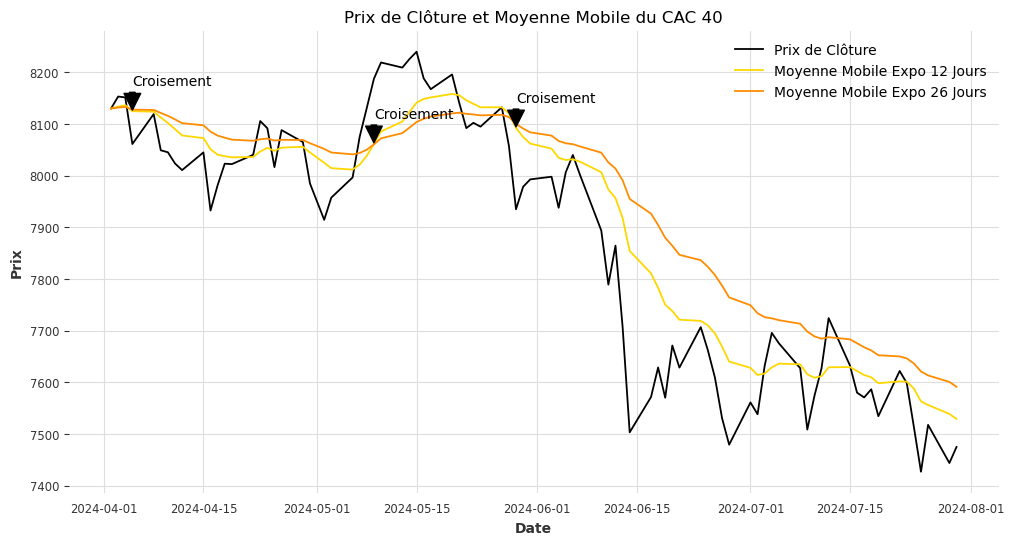

In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date

# On commence par récupérer les données du CAC40 sur yahoo finance
aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices boursiers de Reuters, son ticker est ^FCHI
ticker = '^FCHI'
cac40 = yf.download(ticker, start='2024-04-01', end=aujourdhui)

# Calculer les moyennes mobiles exponentielles (EMA)
cac40['Exp_moyenne_mobile_12'] = cac40['Adj Close'].ewm(span=12, adjust=False).mean()
cac40['Exp_moyenne_mobile_26'] = cac40['Adj Close'].ewm(span=26, adjust=False).mean()


# Identifier les points de croisement : On utilise une condition pour identifier les jours 
# où les EMA se croisent, on utlise .shift(1) pour comparer avec la valeur précédente
crossings = cac40[(cac40['Exp_moyenne_mobile_12'] > cac40['Exp_moyenne_mobile_26']) & 
                  (cac40['Exp_moyenne_mobile_12'].shift(1) < cac40['Exp_moyenne_mobile_26'].shift(1)) | 
                  (cac40['Exp_moyenne_mobile_12'] < cac40['Exp_moyenne_mobile_26']) & 
                  (cac40['Exp_moyenne_mobile_12'].shift(1) > cac40['Exp_moyenne_mobile_26'].shift(1))]


print("l'objet crossing : ", crossings)
print("Le type de l'objet crossing : ", type(crossings))
# C'est un dataFrame

# Tracer les prix de clôture et la moyenne mobile
plt.figure(figsize=(12, 6))
plt.plot(cac40['Adj Close'], label="Prix de Clôture")
plt.plot(cac40['Exp_moyenne_mobile_12'], label="Moyenne Mobile Expo 12 Jours", color='gold')
plt.plot(cac40['Exp_moyenne_mobile_26'], label="Moyenne Mobile Expo 26 Jours", color='darkorange')

# Ajouter des annotations aux points de croisement
for index, row in crossings.iterrows():
    plt.annotate('Croisement', xy=(index, row['Exp_moyenne_mobile_12']), 
                 xytext=(index, row['Exp_moyenne_mobile_12']+50),
                 arrowprops=dict(facecolor='black', shrink=0.05))


plt.title("Prix de Clôture et Moyenne Mobile du CAC 40")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)

#### Explications sur la manière dont le facteur a été choisi

# Analyse Technique

L'analyse technique est basée sur l'idée que les prix des actifs financiers suivent des tendances et que ces tendances peuvent être identifiées et exploitées pour prendre des décisions de trading. Contrairement à l'analyse fondamentale, qui se concentre sur les états financiers, les perspectives de croissance et d'autres facteurs économiques, l'analyse technique utilise des graphiques et divers indicateurs pour prévoir les mouvements futurs des prix.

# Moyennes Mobiles

Les moyennes mobiles sont l'un des outils les plus simples et les plus utilisés en analyse technique. Elles servent à lisser les fluctuations de prix sur une certaine période, ce qui permet d'identifier plus facilement les tendances sous-jacentes.

- **Moyenne mobile simple (SMA)** : Calculée en faisant la moyenne des prix de clôture sur une période donnée.
- **Moyenne mobile exponentielle (EMA)** : Donne plus de poids aux prix récents, ce qui la rend plus réactive aux nouveaux mouvements de prix.

# Croisement de Moyennes Mobiles

Le croisement de moyennes mobiles est une stratégie couramment utilisée pour générer des signaux d'achat et de vente :

- **Croisement Haussier (Golden Cross)** : Se produit lorsque la moyenne mobile à court terme (par exemple, 50 jours) dépasse la moyenne mobile à long terme (par exemple, 200 jours). Cela est considéré comme un signal d'achat car il indique que les prix récents augmentent plus rapidement que les prix historiques, suggérant une tendance haussière.
- **Croisement Baissier (Death Cross)** : Se produit lorsque la moyenne mobile à court terme descend en dessous de la moyenne mobile à long terme. Cela est considéré comme un signal de vente car il indique que les prix récents diminuent plus rapidement que les prix historiques, suggérant une tendance baissière.

# Raisonnement Derrière le Croisement de Moyennes Mobiles

- **Confirmation de Tendance** : Les croisements de moyennes mobiles aident à confirmer le début d'une nouvelle tendance. Par exemple, un croisement haussier suggère qu'une nouvelle tendance haussière pourrait commencer.
- **Filtrage du Bruit** : En utilisant des moyennes mobiles, les traders peuvent filtrer les fluctuations de prix mineures (ou "bruit") et se concentrer sur les mouvements de prix plus significatifs.
- **Signal de Momentum** : Un croisement haussier indique un regain de momentum haussier, tandis qu'un croisement baissier indique un regain de momentum baissier.


[*********************100%%**********************]  1 of 1 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


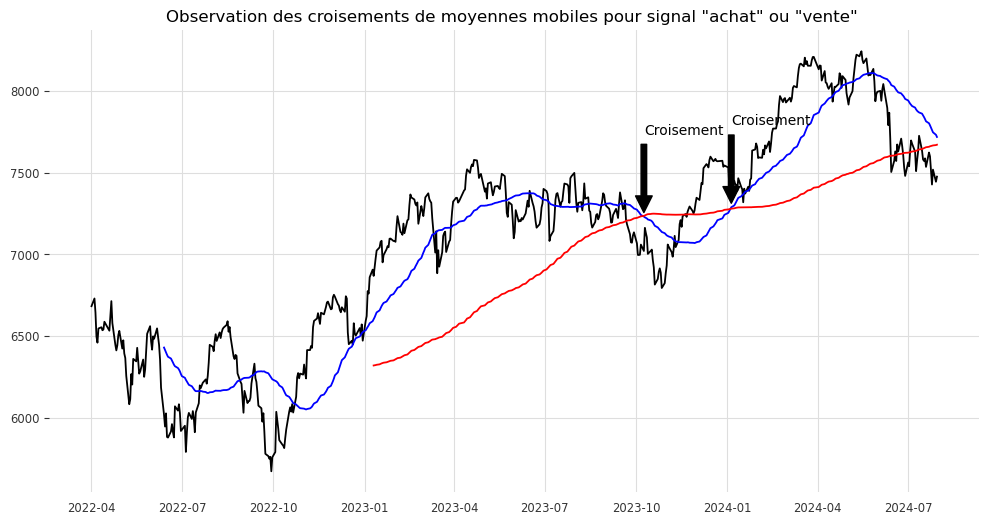

In [10]:
# Pour éviter de polluer le graphique avec des textes de mise en garde on importe warnings
# et on demande à ignorer les warnings
import warnings
warnings.filterwarnings("ignore")

# Utilisons le concept de base de croisement entre la moyenne mobile 50 et la moyenne mobile 200

# On commence par récupérer les données du CAC40 sur yahoo finance sur une période plus longue
# que précédemment car on va utiliser des moyennes mobiles qui prennent en compte 200 jours et 50 jours
aujourdhui = date.today()
aujourdhui = aujourdhui.strftime('%Y-%m-%d')

# le CAC40 a un ticker qui correspond aux standards de la convention de dénomination des indices boursiers de Reuters, son ticker est ^FCHI
ticker = '^FCHI'
cac40 = yf.download(ticker, start='2022-04-01', end=aujourdhui)

plt.figure(figsize=(12, 6))

cac40['Moyenne_mobile_50'] = cac40['Adj Close'].rolling(window=50).mean()
cac40['Moyenne_mobile_200'] = cac40['Adj Close'].rolling(window=200).mean()


# Identifier les croisements
crossings = cac40[(cac40['Moyenne_mobile_50'] > cac40['Moyenne_mobile_200']) & 
                  (cac40['Moyenne_mobile_50'].shift(1) <= cac40['Moyenne_mobile_200'].shift(1)) |
                  (cac40['Moyenne_mobile_50'] < cac40['Moyenne_mobile_200']) & 
                  (cac40['Moyenne_mobile_50'].shift(1) >= cac40['Moyenne_mobile_200'].shift(1))]




# Calcul des signaux d'achat (1) et de vente (-1)
cac40['Signal'] = 0
cac40['Signal'][200:] = np.where(cac40['Moyenne_mobile_50'][200:] > cac40['Moyenne_mobile_200'][200:], 1, -1)

# Identifier les changements dans les signaux pour déterminer les positions d'achat et de vente
cac40['Position'] = cac40['Signal'].diff()

# Extraire les dates et les types de signaux pour annotation
signal_achat = cac40[cac40['Position'] == 2]  # Position de 2 signifie un signal d'achat (1 - (-1))
signal_vente = cac40[cac40['Position'] == -2]  # Position de -2 signifie un signal de vente (-1 -1)


# Ajouter des annotations aux points de croisement
for index, row in crossings.iterrows():
    plt.annotate('Croisement', xy=(index, row['Moyenne_mobile_50']), 
                 xytext=(index, row['Moyenne_mobile_50']+500),
                 arrowprops=dict(facecolor='black', shrink=0.05))

plt.plot(cac40['Adj Close'])
plt.plot(cac40['Moyenne_mobile_50'], color='blue')
plt.plot(cac40['Moyenne_mobile_200'], color='red')
plt.title('Observation des croisements de moyennes mobiles pour signal "achat" ou "vente" ')
plt.legend()

### Le graphique est très clair mais plus précisément quels jours on aurait dû acheter ou vendre ? 

In [11]:
jour_de_vente = signal_vente.index.strftime('%Y-%m-%d')
jour_de_vente_list = jour_de_vente.tolist()
jour_de_vente_list = ''.join(jour_de_vente_list)
print('Il fallait vendre le : ', jour_de_vente_list)

Il fallait vendre le :  2023-10-09


In [12]:
jour_achat = signal_achat.index.strftime('%Y-%m-%d')
jour_achat_list = jour_achat.tolist()
jour_achat_list = ''.join(jour_achat_list)
print('Il fallait acheter le : ', jour_achat_list)

Il fallait acheter le :  2024-01-05


### Prédiction à l'aide des séries temporelles 
#### Partie plus technique réservée au initiés

[*********************100%%**********************]  1 of 1 completed


Valeurs manquantes avant nettoyage: 0
Valeurs manquantes après nettoyage: 0
                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  512
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -2983.095
Date:                Wed, 31 Jul 2024   AIC                           5978.190
Time:                        12:12:30   BIC                           6003.596
Sample:                             0   HQIC                          5988.151
                                - 512                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8532      0.036    -23.474      0.000      -0.924      -0.782
ar.L2         -0.7039      0.051    -13.920      0.000 

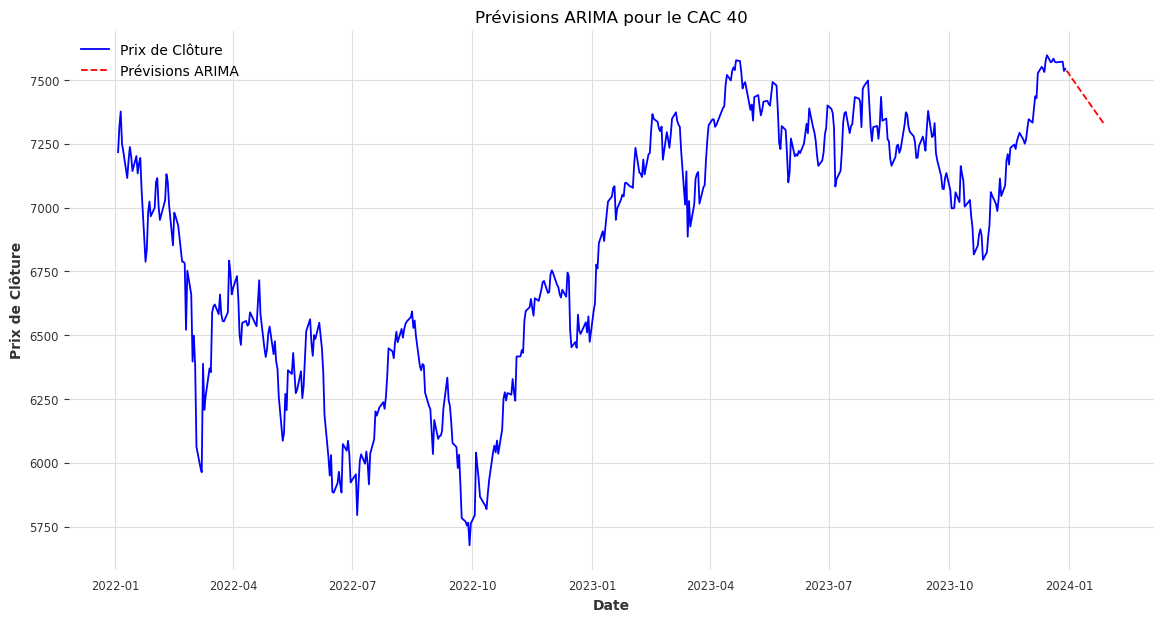

In [38]:
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Télécharger les données du CAC40
ticker = '^FCHI'
data = yf.download(ticker, start='2022-01-01', end='2024-01-01')

# Utiliser la colonne 'Adj Close'
ts = data['Adj Close']

# Vérifier et nettoyer les données
print("Valeurs manquantes avant nettoyage:", ts.isnull().sum())
ts = ts.dropna()
print("Valeurs manquantes après nettoyage:", ts.isnull().sum())

# Ajuster le modèle ARIMA
try:
    model = ARIMA(ts, order=(5, 2, 0))  # Essayez (1, 1, 0) comme alternative
    model_fit = model.fit()
    print(model_fit.summary())
except Exception as e:
    print(f"Erreur lors de l'ajustement du modèle ARIMA: {e}")

# Prédictions
forecast_steps = 30
try:
    forecast = model_fit.get_forecast(steps=forecast_steps)
    forecast_series = forecast.predicted_mean
    forecast_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(days=1), periods=forecast_steps, freq='D')
    forecast_series.index = forecast_index
except Exception as e:
    print(f"Erreur lors de la génération des prévisions: {e}")

# Vérifier les prévisions
print("Prévisions:")
print(forecast_series)

# Tracer les résultats
plt.figure(figsize=(14, 7))
plt.plot(ts, label='Prix de Clôture', color='blue')
if 'forecast_series' in locals() and not forecast_series.empty:
    plt.plot(forecast_series, color='red', linestyle='--', label='Prévisions ARIMA')
plt.title('Prévisions ARIMA pour le CAC 40')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.grid(True)
plt.show()

### Régression polynomiale pour tenter de capturer une éventuelle tendance non linéaire (à priori non évidente)

Erreur Quadratique Moyenne : 295.72428567813296
Coefficient de Détermination (R^2) : 0.7808768017864005


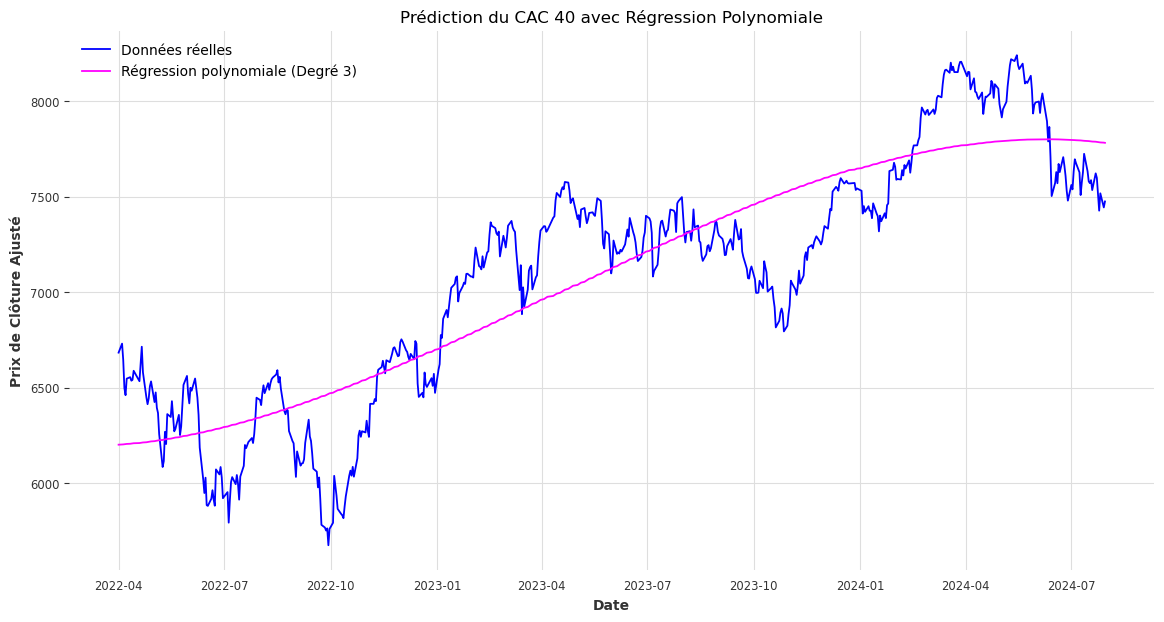

In [14]:
from sklearn.metrics import mean_squared_error, r2_score 

# On transforme l'index des jours en nombres entier pour pouvoir régresser les ordonnées sur les abcsisses

X = np.arange(len(cac40['Adj Close'])).reshape(-1,1)
y = cac40['Adj Close']

degre_polynome = 3
polynome_caracteristiques = PolynomialFeatures(degree=degre_polynome) 
X_polynome = polynome_caracteristiques.fit_transform(X)

modele = LinearRegression()
modele.fit(X_polynome, y)
y_polynome_prediction = modele.predict(X_polynome)


erreur_quadratique_moyenne = np.sqrt(mean_squared_error(y, y_polynome_prediction))
r2 = r2_score(y, y_polynome_prediction)
print(f"Erreur Quadratique Moyenne : {erreur_quadratique_moyenne}")
print(f"Coefficient de Détermination (R^2) : {r2}")


plt.figure(figsize=(14, 7))
plt.plot(cac40.index, y, label='Données réelles', color='blue')
plt.plot(cac40.index, y_polynome_prediction, color='magenta', label='Régression polynomiale (Degré 3)')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture Ajusté')
plt.title('Prédiction du CAC 40 avec Régression Polynomiale')
plt.legend()

### Automatiser le processus pour trouver le meilleur degré du polynome et mettre une explication du pourquoi on transforme d'abord les X puis on fait une régression linéaire, penser à revoir le facteur exponentiel et son calcul 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


La liste mse TEST :  [(1, 87669.42376465288), (2, 87286.79001611742), (3, 79433.65303825507), (4, 74137.45705399176), (5, 44879.038893083394), (6, 32134.903798957897), (7, 47258.37071006065), (8, 45646.14061062243), (9, 36689.50443868271), (10, 34248.492483901406), (11, 43402.4451441983), (12, 61622.42497817854), (13, 83024.67476730287), (14, 102759.02653342386), (15, 118662.03680179766)] 

La liste R2 test :  [(1, 0.7947787641165233), (2, 0.7956744534845289), (3, 0.8140574929406286), (4, 0.8264551093352495), (5, 0.8949447660152798), (6, 0.924776913210673), (7, 0.8893750999322935), (8, 0.8931490936387361), (9, 0.9141152625221822), (10, 0.9198293127423747), (11, 0.8984012549601312), (12, 0.8557509600370224), (13, 0.8056514388607255), (14, 0.7594562218181848), (15, 0.7222296121132498)] 

Best degree MSE variable :  (6, 32134.903798957897) 

Best degree R2 variable :  (6, 0.924776913210673) 

Meilleur degré basé sur l'Erreur Quadratique Moyenne (MSE) : 6 avec MSE = 32134.903798957897 

Me

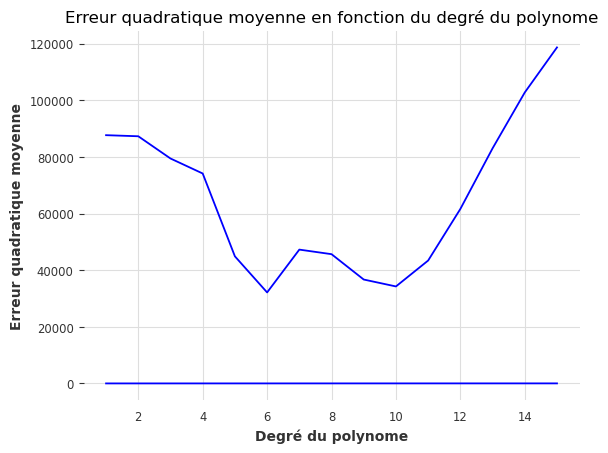

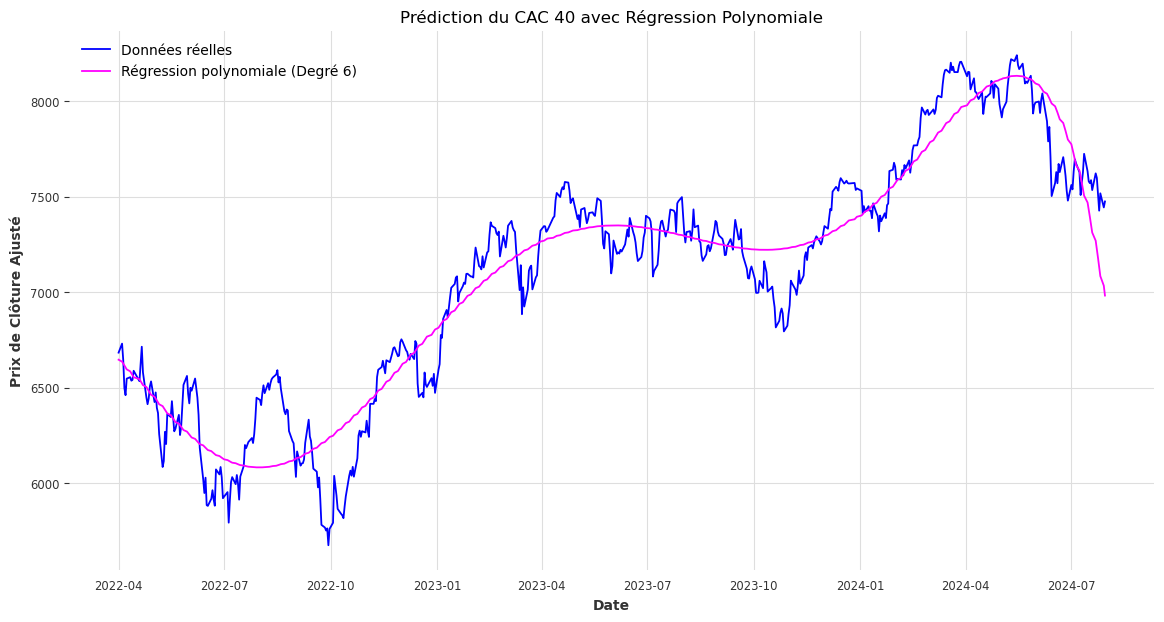

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# Assurez-vous d'avoir les données dans le DataFrame cac40
# Exemple : cac40 = pd.read_csv('path_to_your_cac40_data.csv')

# Transformation de l'index des jours en nombres entiers pour la régression
X = np.arange(len(cac40['Adj Close'])).reshape(-1, 1)
y = cac40['Adj Close']

# Définir la gamme de degrés de polynômes à tester
degres_polynome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Initialiser des listes pour stocker les résultats
mse_list = []
r2_list = []

# Diviser les données en ensemble d'entraînement et ensemble de test
# de cette manière on pourra tester notre modèle entraîné sur 80% des données sur les 20% de données
# non utilisées et on regardera combien vaut la moyenne quadratique des erreurs sur cette partie
# non entraînée. Le modèle qui nous donnera la moyenne quadratique la plus petite sera le meilleur
# modèle, celui que nous garderons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Boucle sur les différents degrés de polynômes
for degre_polynome in degres_polynome:
    # Créer les caractéristiques polynomiales
    polynome_caracteristiques = PolynomialFeatures(degree=degre_polynome)
    X_train_polynome = polynome_caracteristiques.fit_transform(X_train)
    X_test_polynome = polynome_caracteristiques.transform(X_test)
    
    # Ajuster le modèle de régression linéaire
    modele = LinearRegression()
    modele.fit(X_train_polynome, y_train)
    
    # Prédictions
    y_train_prediction = modele.predict(X_train_polynome)
    y_test_prediction = modele.predict(X_test_polynome)
    
    # Évaluer les performances
    mse_train = mean_squared_error(y_train, y_train_prediction)
    r2_train = r2_score(y_train, y_train_prediction)
    mse_test = mean_squared_error(y_test, y_test_prediction)
    r2_test = r2_score(y_test, y_test_prediction)
    
    # On ajoute à la liste vide le couple erreur quadratique sur le dataset TEST 
    # avec le degré du polynome à côte pour pouvoir observer dans cette liste le degré polynome
    # et son erreur associée afin de juger lequel est le meilleur
    # On ajouter à la liste un tuple (degré, erreur)
    mse_list.append((degre_polynome, mse_test))
    
    # On fait pareil pareil pour le R2, sachant qu'une erreur plus petite donne un meilleur R2
    # la relation est inverse
    r2_list.append((degre_polynome, r2_test))
    
print('La liste mse TEST : ', mse_list, '\n')
print('La liste R2 test : ', r2_list, '\n')

# Trouver le meilleur degré basé sur MSE ou R^2
best_degree_mse = min(mse_list, key=lambda x: x[1])
best_degree_r2 = max(r2_list, key=lambda x: x[1])

print('Best degree MSE variable : ', best_degree_mse, '\n')
print('Best degree R2 variable : ', best_degree_r2, '\n')

print(f"Meilleur degré basé sur l'Erreur Quadratique Moyenne (MSE) : {best_degree_mse[0]} avec MSE = {best_degree_mse[1]}", '\n')
print(f"Meilleur degré basé sur le Coefficient de Détermination (R^2) : {best_degree_r2[0]} avec R^2 = {best_degree_r2[1]}", '\n')

# Visualiser les erreurs en fonction du degré choisi pour observer visuellement qu'on est
# à la plus petite erreur avec le polynome de degré 6
plt.plot(degres_polynome, mse_list, color='blue')
plt.xlabel('Degré du polynome')
plt.ylabel('Erreur quadratique moyenne')
plt.title('Erreur quadratique moyenne en fonction du degré du polynome')
plt.legend()

# Visualiser les résultats pour le meilleur degré
degre_optimal = best_degree_mse[0]  # Choisissez le meilleur degré basé sur votre critère

# Re-créer le modèle pour le meilleur degré
polynome_caracteristiques = PolynomialFeatures(degree=degre_optimal)
X_polynome = polynome_caracteristiques.fit_transform(X)
modele = LinearRegression()
modele.fit(X_polynome, y)
y_polynome_prediction = modele.predict(X_polynome)

plt.figure(figsize=(14, 7))
plt.plot(cac40.index, y, label='Données réelles', color='blue')
plt.plot(cac40.index, y_polynome_prediction, color='magenta', label=f'Régression polynomiale (Degré {degre_optimal})')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture Ajusté')
plt.title('Prédiction du CAC 40 avec Régression Polynomiale')
plt.legend()

#### Une fois qu'on a trouvé le modèle qui minimise les erreurs on va tenter de réaliser une prédiction et de l'afficher sur un graphique avec ce modèle

In [16]:
cac40['Adj Close'].index[-1]

Timestamp('2024-07-30 00:00:00')

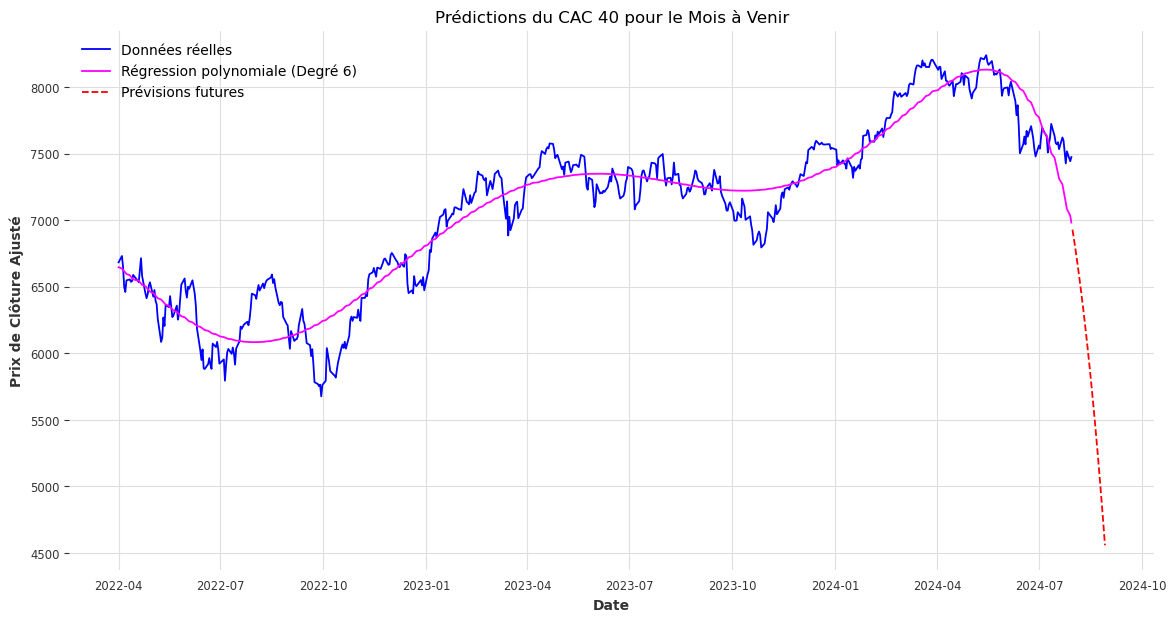

In [17]:
# Préparation pour les prédictions futures
# Supposons que vous voulez prédire pour les 30 prochains jours
n_days_future = 30
dernier_jour = len(cac40['Adj Close']) - 1
nouveaux_jours = np.arange(dernier_jour + 1, dernier_jour + 1 + n_days_future).reshape(-1, 1)

# Créer les caractéristiques polynomiales pour les jours futurs
nouveau_polynome_caracteristiques = PolynomialFeatures(degree=degre_optimal)
nouveaux_jours_polynome = nouveau_polynome_caracteristiques.fit_transform(nouveaux_jours)

# Réaliser les prédictions pour les jours futurs
predictions_futures = modele.predict(nouveaux_jours_polynome)

# Générer les dates futures en ajoutant des jours au dernier jour connu
# On récupère la dernière date de note dataset CAC40 avec le sélecteur [-1]
derniere_date = cac40.index[-1]

# ici pour générer les dates futures qui vont apparaître sur le graphique
# on fait une boucle qui va de i=1 à i=30 (n_days_future = 30), on écrit +1 pour aller jusqu'à 31
# car la boucle prend jamais en compte le dernier chiffre, elle s'arrête un indice plus tôt
# donc quand on précise qu'on veut aller jusqu'à 31 la boucle va jusqu'à 30 en fait
dates_futures = [derniere_date + pd.DateOffset(days=i) for i in range(1, n_days_future + 1)]

# la partie suivante : derniere_date + pd.DateOffset(days=i) utilise en fait la boucle qui crée
# des jours de 1 à 30 et prend la dernière date du dataset et lui ajoute les dates suivantes.
# Mais attention, si on prend la dernière date et qu'on lui ajoute 1 ou 2 ou 3 etc... ça ne fonctionne
# pas. Pourquoi ? Parcequ'on ne peut pas ajouter directement à une Date un chiffre pour avoir la date 
# suivante. D'où l'intérêt de pd.DataOffset(days=i) qui va nous permettre d'ajouter à la dernière
# date du dataset le chiffre 'i', par exemple au début de la boucle i=1 donc on va ajouter '1'
# à la dernière date du dataset et mieux encore, pd.DateOffset(days=i) permet de transformer ce +1
# en date directement. Autrement dit il permet d'ajouter +1 direct sous forme de date à la dernière date.
# donc si la dernière date est le 27 juillet, alors la suivante, le 28 juillet, sera crée grâce à
# cette fonction. 

# Afficher les résultats
plt.figure(figsize=(14, 7))
plt.plot(cac40.index, y, label='Données réelles', color='blue')
plt.plot(cac40.index, y_polynome_prediction, color='magenta', label=f'Régression polynomiale (Degré {degre_optimal})')
plt.plot(dates_futures, predictions_futures, color='red', linestyle='--', label='Prévisions futures')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture Ajusté')
plt.title('Prédictions du CAC 40 pour le Mois à Venir')
plt.legend()

### Un peu pessimiste avec ce modèle n'est-ce pas ? :)

In [18]:
# Cellule de code juste pour comprendre le fonctionnement de la création de dates à venir réalisée
# dans la cellule précédente

last_date = cac40.index[-1]

full_periode = []
for i in range(1, 31):
    jour_apres = last_date + pd.DateOffset(days=i)
    full_periode.append(jour_apres)

full_periode

[Timestamp('2024-07-31 00:00:00'),
 Timestamp('2024-08-01 00:00:00'),
 Timestamp('2024-08-02 00:00:00'),
 Timestamp('2024-08-03 00:00:00'),
 Timestamp('2024-08-04 00:00:00'),
 Timestamp('2024-08-05 00:00:00'),
 Timestamp('2024-08-06 00:00:00'),
 Timestamp('2024-08-07 00:00:00'),
 Timestamp('2024-08-08 00:00:00'),
 Timestamp('2024-08-09 00:00:00'),
 Timestamp('2024-08-10 00:00:00'),
 Timestamp('2024-08-11 00:00:00'),
 Timestamp('2024-08-12 00:00:00'),
 Timestamp('2024-08-13 00:00:00'),
 Timestamp('2024-08-14 00:00:00'),
 Timestamp('2024-08-15 00:00:00'),
 Timestamp('2024-08-16 00:00:00'),
 Timestamp('2024-08-17 00:00:00'),
 Timestamp('2024-08-18 00:00:00'),
 Timestamp('2024-08-19 00:00:00'),
 Timestamp('2024-08-20 00:00:00'),
 Timestamp('2024-08-21 00:00:00'),
 Timestamp('2024-08-22 00:00:00'),
 Timestamp('2024-08-23 00:00:00'),
 Timestamp('2024-08-24 00:00:00'),
 Timestamp('2024-08-25 00:00:00'),
 Timestamp('2024-08-26 00:00:00'),
 Timestamp('2024-08-27 00:00:00'),
 Timestamp('2024-08-

### Pourquoi notre modèle semble douteux ? 
### Regardons tout d'abord en détail comment nous avons procédé :

La cellule ci-dessous vous montre de manière simple et sous forme de régression LINEAIRE comment nous avons procédé pour anticiper le CAC40. Notons que ci-dessus nous avons utilisé une régression polynomiale et non linéaire, mais le raisonnement est exactement le même et pour des raisons pédagogiques il est vraiment plus simple d'expliquer notre procédé avec une illustration linéraire ;)

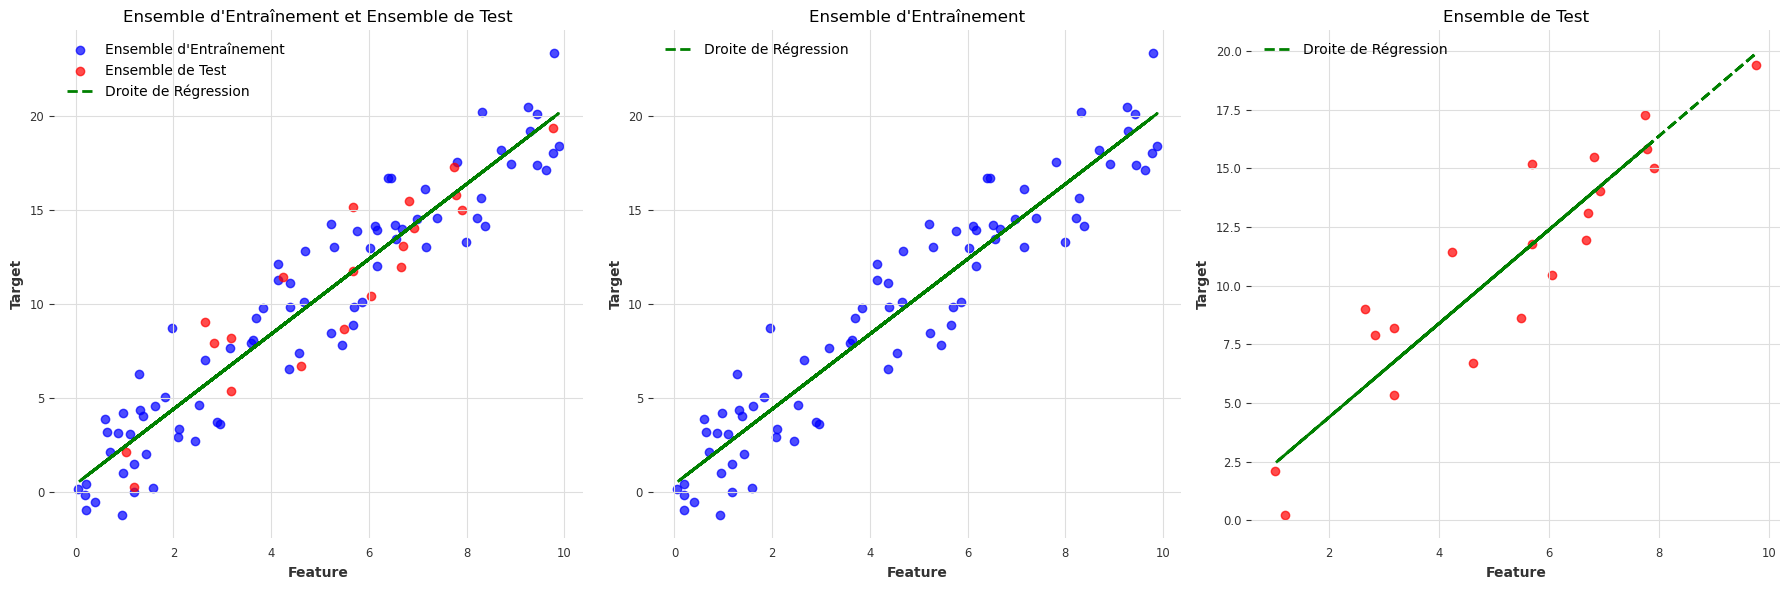

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Fixer la graine pour la reproductibilité
np.random.seed(0)

# Générer des données fictives aléatoirement on génrère une série de 100 points uniforméments
# distribués entre 0 et 1 et pour un meilleur visuel on multiplie par 10 pour avoir une fourchette
# entre [0, 10]
X = np.random.rand(100, 1) * 10

# Créer le bruit aléatoire
# même principe, plus commun cependant d'utiliser une distribution Gaussienne d'où la petite
# subtibilité dans le code avec l'utilisation de .randn --> le 'n' pour 'normal' plutôt que
# np.random.rand(100, 1) * 10
# la multiplication par 2 est arbitraire mais 2 étant plus petit que 10, le bruit sera léger ;)
bruit = np.random.randn(100, 1) * 2

# La vraible 'y' de l'axe des ordonnées la conséquence de la variable X et du bruit 
y = 2 * X + bruit

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle de régression linéaire
modele = LinearRegression()
modele.fit(X_train, y_train)

# Calculer les prédictions
y_train_pred = modele.predict(X_train)
y_test_pred = modele.predict(X_test)

# Créer les sous-graphiques
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Graphique combiné
axs[0].scatter(X_train, y_train, color='blue', label='Ensemble d\'Entraînement', alpha=0.7)
axs[0].scatter(X_test, y_test, color='red', label='Ensemble de Test', alpha=0.7)
axs[0].plot(X_train, modele.predict(X_train), color='green', linestyle='--', label='Droite de Régression', linewidth=2)
axs[0].set_title('Ensemble d\'Entraînement et Ensemble de Test')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('Target')
axs[0].legend()

# Ensemble d'entraînement
axs[1].scatter(X_train, y_train, color='blue', alpha=0.7)
axs[1].plot(X_train, modele.predict(X_train), color='green', linestyle='--', label='Droite de Régression', linewidth=2)
axs[1].set_title('Ensemble d\'Entraînement')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Target')
axs[1].legend()

# Ensemble de test
axs[2].scatter(X_test, y_test, color='red', alpha=0.7)
axs[2].plot(X_test, modele.predict(X_test), color='green', linestyle='--', label='Droite de Régression', linewidth=2)
axs[2].set_title('Ensemble de Test')
axs[2].set_xlabel('Feature')
axs[2].set_ylabel('Target')
axs[2].legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

#### Vous avez compris ?
#### Nous avons sélectionné aléatoirement 80% de ns données pour entraîner un modèle
#### puis nous avons testé notre modèle sur les 20% des données restantes. Autrement dit, 
#### celles que notre modèle ne connaît pas. Pourquoi ? Pour tester si notre modèle entraîné sur
#### 80% du dataset réalise de bonnes prédictions sur les 20% de données encore inconnues. 
#### Intéressant n'est-ce pas ?

SAUF QUE : Un cours de bourse est une série temporelle et dans une série temporelle la date 28 juillet 2024 et celle qui suit le 27 juillet 2023..... EUH... Et donc ?    

  
  
Et bien il existe une influence du temps qui passe et une sorte de dépendance du présent au passé même si elle peut être faible. Et puis.... les dates se suivent, donc choisir au hasard des dates un peu partout à droite à gauche, entraîner notre modèle et venir le tester sur les 20% de dates restantes elles-mêmes étant aléatoires ???  
  
  ça ne signifie pas grand chose... En fait cette méthode est intéressante mais plutôt sur une coupe transversale et non sur une série temporelle. Mais au moins, ce soir vous dormirez plus sereinement en ayant appris ceci n'est-ce pas ? ;)  
    
    Ci-dessous une explication plus rigoureuse : 

Il est vrai que les modèles de régression polynomiale peuvent parfois donner des résultats décevants lorsqu'ils sont appliqués à des données boursières pour plusieurs raisons. Voici quelques points clés expliquant pourquoi une régression polynomiale pourrait prédire mal les cours de bourse :

1. **Nature des Données Boursières**

   - **Non-Stationnarité** : Les données boursières sont souvent non-stationnaires, c'est-à-dire que leurs propriétés statistiques changent au fil du temps. Les modèles polynomiaux, qui supposent une relation fixe entre les variables, peuvent mal gérer ces changements dans les données.

   - **Comportement Stochastique** : Les marchés financiers sont influencés par de nombreux facteurs imprévisibles et aléatoires (actualités économiques, politiques, etc.), rendant les prévisions très difficiles.

2. **Overfitting**

   - **Complexité du Modèle** : Les polynômes de degré élevé peuvent s'ajuster très bien aux données d'entraînement mais mal se généraliser sur des données de test. Cela se traduit par un surapprentissage (overfitting), où le modèle est trop complexe et s'ajuste aux bruits des données d'entraînement au lieu de capturer la tendance générale.

   - **Biais et Variance** : Un polynôme de degré élevé a une variance élevée, ce qui signifie qu'il peut être très sensible aux variations dans les données d'entraînement. Ce surajustement réduit sa capacité à prédire des données nouvelles de manière fiable.

3. **Simplicité du Modèle**

   - **Modèle Linéaire vs. Complexité des Données** : Les polynômes, même de degré élevé, sont encore des modèles relativement simples par rapport aux modèles plus sophistiqués comme les réseaux neuronaux ou les modèles de séries temporelles comme ARIMA, qui peuvent capturer des dépendances temporelles complexes.

   - **Absence de Variables Exogènes** : Les modèles polynomiaux ne prennent pas en compte d'autres variables exogènes (telles que des indicateurs économiques, des événements géopolitiques, etc.) qui peuvent influencer les prix des actions.

4. **Choix du Degré du Polynôme**

   - **Détermination du Degré** : Le choix du degré du polynôme est crucial. Un degré trop bas peut sous-ajuster les données (ne pas capturer la tendance), tandis qu'un degré trop élevé peut surajuster (capturer le bruit).

   - **Validation Croisée** : Il est important d'utiliser des techniques de validation croisée pour choisir le meilleur degré du polynôme et éviter le surajustement.

5. **Caractéristiques des Données**

   - **Transformation des Données** : Les données boursières peuvent nécessiter des transformations ou des prétraitements pour améliorer les performances du modèle. Par exemple, la prise en compte des rendements logistiques ou des changements de pourcentage peut fournir une meilleure modélisation des variations.

6. **Mesures de Performance**

   - **Évaluation des Performances** : Il est essentiel d'évaluer le modèle non seulement avec des erreurs quadratiques moyennes ($MSE$) mais aussi avec des métriques qui tiennent compte de la nature des données financières, comme le retour sur investissement, la volatilité, etc.


## Ridge Lasso

#### Chers amis nous allons passer à une estimation à l'aide de la régression Ridge et la régression Lasso, en règle générale quand on fait du machine learning, on crée un modèle qui apprend à partir des données qu'on lui fournit et qui essaie d'être le moins mauvais possible, ou encore le best model ! Et pour faire celà il est très classique d'entraîner le modèle sur une partie seulement des données. Pourquoi ? Pour pouvoir ensuite lancer le modèle sur l'autre partie des données dont on a connaissance et que le modèle lui ne connaît pas encore étant donné qu'il a été entraîné seulement sur une autre partie. Purquoi faire celà ? Pour pouvoir vérifier sur des données qu'on connaît comment performe le modèle. Ingénieux n'est-ce pas ? 

Pour obtenir le meilleur modèle, une manière efficace et de regarder à quel point il se trompe une fois qu'on l'applique à des données dont on connaît déjà la réalisation. Et le classique consiste à utiliser une fonction de 'coût'. Plus on fait d'erreurs dans la prédiction plus le 'coût' est élevé. La fonction de coût classique est celle de la somme des erreurs élevées au carré. Le but est de minimiser cette fonction pour avoir les erreurs les plus petites possibles. Pour celà on peut générer un modèle avec des paramètres, itérer en essayant plusieurs valeurs pour ces paramètres, et retenir les paramètres qui donnent un total d'erreurs au carré le plus petit possible. 

$J(\beta) = \sum_{i=1}^{m} \left( y_i - \hat{y}_i \right)^2$


Voilà ci-dessus la plus classique des fonctions de coût, elle représente la somme des $\left( y_i - \hat{y}_i \right)^2$, autrement dit la somme des valeurs observées $y_i$ auquelles on retranche la valeur prédite par le modèle $\hat{y}_i$. Regardez bien cette soustraction et remarquez que si les valeurs prédites par le modèles $\hat{y}_i$ sont égales aux valeurs observées en vrai $y_i$, alors le modèle est parfait et les erreurs valent 0

#### La régression Ridge et la régression Lasso modifient cette fonction de coût pour améliorer le modèle. Pourquoi ? Les maths sont un peu complexes à ce propos, pour être bref, il est possible que notre modèle soit excellent voire même un peu trop parfait quand on l'entraîne sur nos données, tellement parfait sur note dataset que dans la vrai vie, si on l'utilise sur d'autres données il ne sera pas très bon pour les prédire. Il aura tellement été bien entraîné sur des données spécifiques qu'il sera moyen à prédire des données plus générales. On appelle ce phénomène l'overfitting !

Enfin pour diminuer ce genre de problème, Ridge et Lasso modifient un peu la fonction de coût de la manière suivante afin de diminuer l'overfitting : 

RIDGE : $J(\beta) = \sum_{i=1}^{m} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{n} \beta_j^2$


LASSO : $J(\beta) = \sum_{i=1}^{m} \left( y_i - \hat{y}_i \right)^2 + \lambda \sum_{j=1}^{n} |\beta_j|$


Une vidéo rapide sur le sujet : https://www.youtube.com/watch?v=-Wl2px-jW1A

Une vidéo plus précise sur le sujet : https://www.youtube.com/watch?v=Q81RR3yKn30

Nous reparlerons plus tard de la cross validation qui permet de choisir le $\lambda $ optimal pour RIDGE ou LASSO

[*********************100%%**********************]  1 of 1 completed


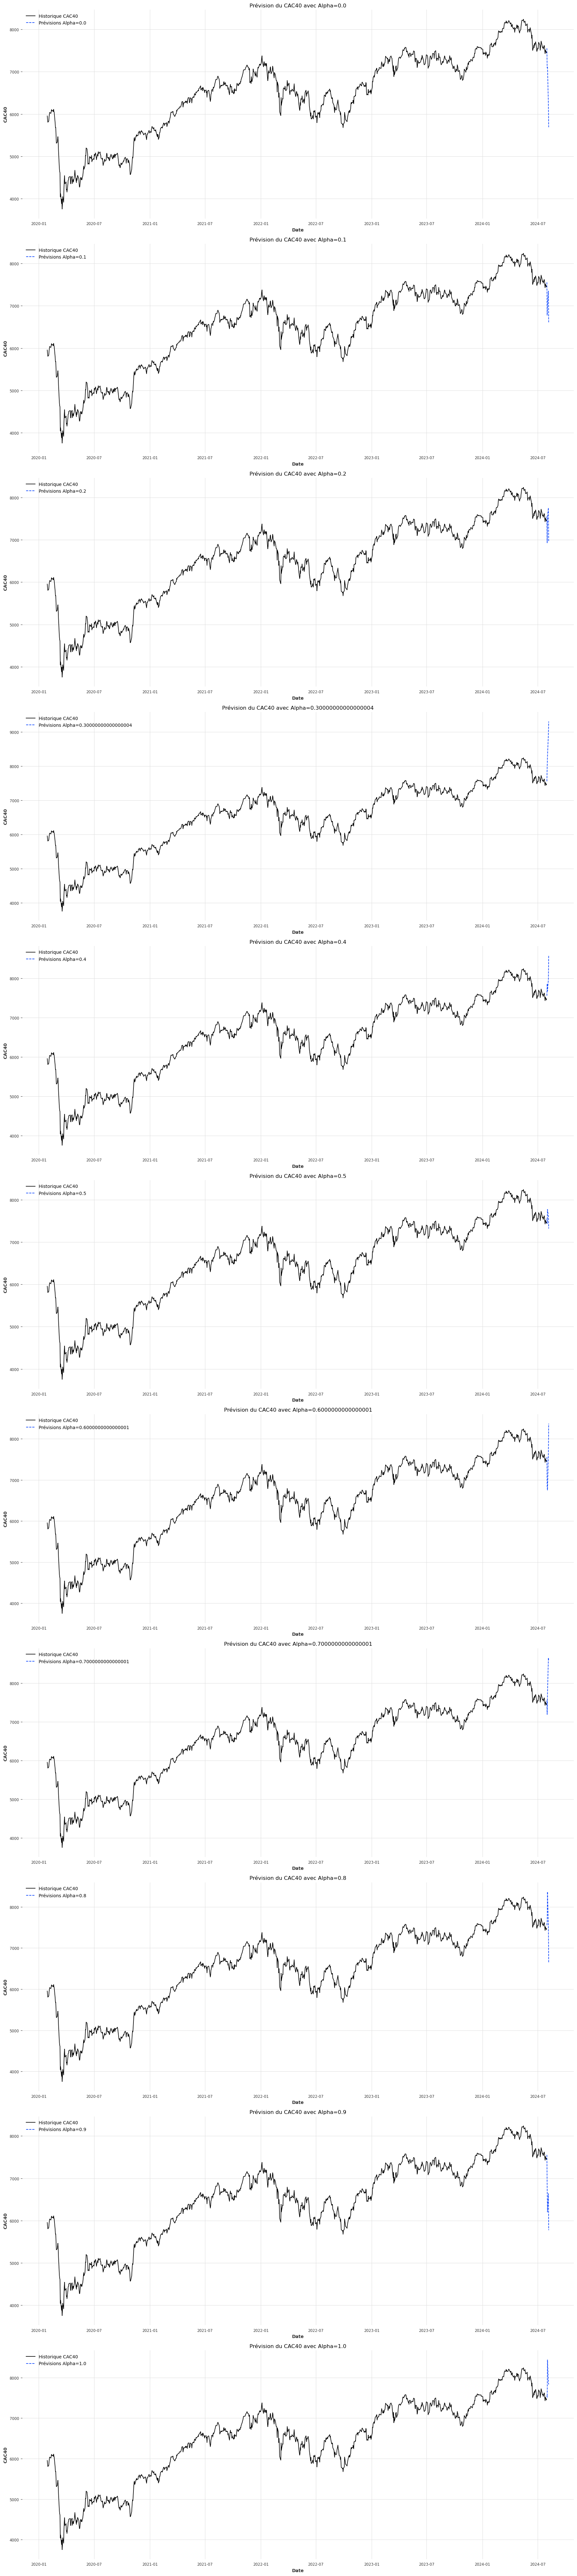

In [57]:
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Télécharger les données du CAC40 depuis Yahoo Finance
ticker = '^FCHI'  # Symbole pour le CAC40
data = yf.download(ticker, start='2020-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Récupérer les données d'inflation depuis FRED
def get_inflation_data():
    # Taux d'inflation CPIAUCNS (Consumer Price Index for All Urban Consumers: All Items)
    inflation_data = pdr.get_data_fred('CPIAUCNS', start='2020-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))
    inflation_data = inflation_data.resample('D').ffill()  # Remplir les jours manquants par propagation
    inflation_data['Inflation'] = inflation_data['CPIAUCNS'].pct_change() * 100  # Calculer le taux d'inflation en pourcentage
    inflation_data = inflation_data[['Inflation']]
    inflation_data.index = inflation_data.index.date  # Convertir les dates en format 'date'
    return inflation_data

inflation_data = get_inflation_data()

# Fusionner les données d'inflation avec les données du CAC40
data = data.join(inflation_data, how='left')
data['Inflation'] = data['Inflation'].fillna(method='ffill')  # Remplir les valeurs manquantes par propagation

# Calculer les caractéristiques
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().apply(lambda x: (1 + x) / (1 - x)).rolling(window=14).mean()))
data['Volume'] = data['Volume']

# Supprimer les valeurs manquantes
data = data.dropna()

# Préparer les caractéristiques et la cible
X = data[['SMA_20', 'RSI', 'Volume', 'Inflation']]
y = data['Close']

# Normaliser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Définir les valeurs de alpha pour Ridge
alphas = np.linspace(0, 1, 11)  # 11 valeurs de alpha de 0 à 1

# Préparer les données pour les prédictions futures
future_predictions_dict = {}

# Créer une figure avec des sous-graphes
plt.figure(figsize=(18, 80))

for i, alpha in enumerate(alphas):
    # Créer et entraîner le modèle Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)

    # Préparer les données pour les prédictions futures
    last_known_data = X_scaled[-1].reshape(1, -1)

    # Prédire les 5 jours à venir
    future_predictions = []
    sma_last = X.iloc[-1]['SMA_20']
    rsi_last = X.iloc[-1]['RSI']
    volume_last = X.iloc[-1]['Volume']
    inflation_last = X.iloc[-1]['Inflation']

    for _ in range(5):
        future_pred = ridge_model.predict(last_known_data)
        future_predictions.append(future_pred[0])
        
        # Simuler des caractéristiques futures réalistes
        sma_last += np.random.uniform(-10, 10)
        rsi_last += np.random.uniform(-1, 1)
        volume_last += np.random.uniform(-1000, 1000)
        inflation_last += np.random.uniform(-0.1, 0.1)

        # Préparer les prochaines valeurs de caractéristiques
        next_data = np.array([sma_last, rsi_last, volume_last, inflation_last]).reshape(1, -1)
        last_known_data = scaler.transform(next_data)

    # Convertir les prévisions en DataFrame
    future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')  # Jours de semaine uniquement
    predictions_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted_CAC40'])
    future_predictions_dict[alpha] = predictions_df

    # Ajouter le sous-graphe
    plt.subplot(len(alphas), 1, i + 1)
    plt.plot(data.index, data['Close'], label='Historique CAC40')
    plt.plot(predictions_df.index, predictions_df['Predicted_CAC40'], label=f'Prévisions Alpha={alpha}', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('CAC40')
    plt.title(f'Prévision du CAC40 avec Alpha={alpha}')
    plt.legend()

plt.tight_layout()
plt.show()
